# OSMnx study

This notebook is mainly to obtain building outlines for creating a building mask on statistical data such as booth's coloured-in-houses maps of london

It also contains some other OSMnx features, particularly creating network graphs

In [3]:
import networkx as nx
import osmnx as ox
%matplotlib inline
ox.__version__

'1.2.2'

## Get Buildings

... or any geospatial entities' geometries and attributes in fact!

Use the `geometries` module to download entities, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.geometries). For more usage examples of downloading geospatial objects from OSM, see [this notebook](16-download-osm-geospatial-entities.ipynb).

In [4]:
# get all building footprints in some neighborhood
place = "London Borough of Tower Hamlets, London, UK"
tags = {"building": True}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

(16507, 372)

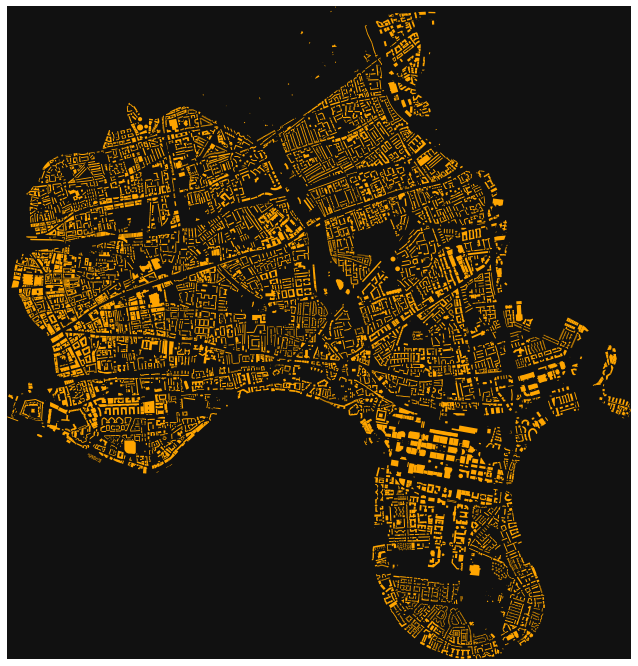

In [76]:
fig, ax = ox.plot_footprints(gdf, figsize=(12, 12))

In [31]:
import geopandas as gpd


In [36]:
try:
  wards = gpd.read_file("../data/external/ons/boundaries/tower-hamlets-wards.geojson")
except Exception:
  wards=gpd.read_file('https://gist.github.com/joel-lbth/6d2c78c52163b7da1d91089c9bd849cf/raw/1ece7857aff95a3729d76313d63bd9cbb495491a/lbth-wards.geojson')

<AxesSubplot:>

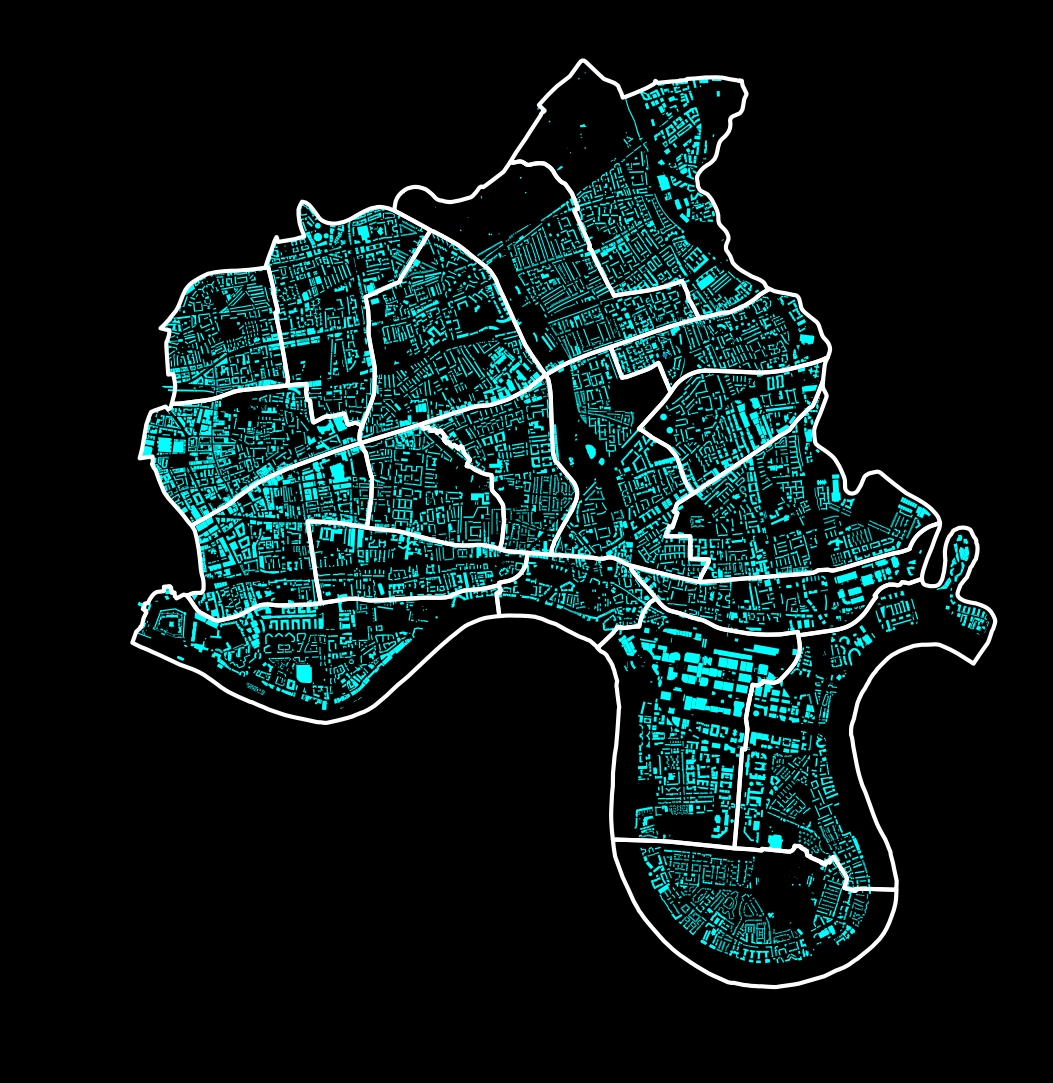

In [41]:
# filter out nodes (points) and relations (objects), just keep ways (lines)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 9), dpi=150, facecolor="black")
ax.set_facecolor("black")
gdf[gdf.index.map(lambda x: x[0].startswith('way'))].plot(ax=ax, facecolor="cyan")
wards.plot(ax=ax, facecolor="none", linewidth=2, edgecolor="white")

## Working with street networks

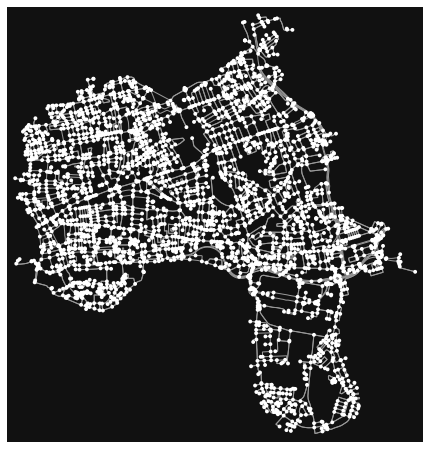

In [57]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place("London Borough of Tower Hamlets, London, UK", network_type="drive")
fig, ax = ox.plot_graph(G)

OSMnx geocodes the query "Piedmont, California, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples.

OSMnx models all networks as NetworkX `MultiDiGraph` objects. You can convert to:
  - undirected MultiGraphs
  - DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

In [58]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.utils_graph.get_digraph(G)

In [59]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
104341,51.514724,-0.030101,3,NaN,POINT (-0.03010 51.51472)
104343,51.515636,-0.028922,3,NaN,POINT (-0.02892 51.51564)
106734,51.509475,-0.060494,4,NaN,POINT (-0.06049 51.50947)
106735,51.520961,-0.056181,3,NaN,POINT (-0.05618 51.52096)
106750,51.514100,-0.036910,3,NaN,POINT (-0.03691 51.51410)


In [10]:
gdf_edges.head()

osmid  \
u      v         key                                                      
104341 104343    0                       [689026946, 50813652, 5027198]   
       107164    0                                              5027301   
       648000849 0                                            616142176   
104343 107164    0                  [226221865, 1046719228, 1046719229]   
       13668650  0    [226221865, 1049740176, 1049740177, 1049740178...   

                                                  name      highway maxspeed  \
u      v         key                                                           
104341 104343    0    [Copenhagen Place, Agnes Street]  residential   20 mph   
       107164    0                       Pixley Street  residential   20 mph   
       648000849 0                    Copenhagen Place  residential   20 mph   
104343 107164    0                        Burdett Road      primary   30 mph   
       13668650  0                        Burdett Road      primary   30 mph   

                      oneway       reversed   length  \
u      v         key                                   
104341 104343    0     False  [False, True]  177.975   
       107164    0     False           True  108.854   
       648000849 0     False          False   23.460   
104343 107164    0     False          False   79.948   
       13668650  0     False           True  158.550   

                                                               geometry lanes  \
u      v         key                                                            
104341 104343    0    LINESTRING (-0.03010 51.51472, -0.03039 51.515...   NaN   
       107164    0    LINESTRING (-0.03010 51.51472, -0.02964 51.514...   NaN   
       648000849 0    LINESTRING (-0.03010 51.51472, -0.03006 51.514...   NaN   
104343 107164    0    LINESTRING (-0.02892 51.51564, -0.02889 51.515...     2   
       13668650  0    LINESTRING (-0.02892 51.51564, -0.02911 51.516...     2   

                        ref tunnel access bridge junction width  
u      v         key                                             
104341 104343    0      NaN    NaN    NaN    NaN      NaN   NaN  
       107164    0      NaN    NaN    NaN    NaN      NaN   NaN  
       648000849 0      NaN    NaN    NaN    NaN      NaN   NaN  
104343 107164    0    A1205    NaN    NaN    NaN      NaN   NaN  
       13668650  0    A1205    NaN    NaN    NaN      NaN   NaN

You can create a graph from node/edge GeoDataFrames, as long as gdf_nodes is indexed by osmid and gdf_edges is multi-indexed by u, v, key (following normal MultiDiGraph structure). This allows you to load graph node/edge shapefiles or GeoPackage layers as GeoDataFrames then convert to a MultiDiGraph for graph analytics.

In [60]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

## Basic street network stats

In [56]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

9273442.799396098

In [55]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 3282,
 'm': 7394,
 'k_avg': 4.505789152955515,
 'edge_length_total': 553771.1549999961,
 'edge_length_avg': 74.89466526913661,
 'streets_per_node_avg': 2.5633759902498476,
 'streets_per_node_counts': {0: 0,
  1: 773,
  2: 129,
  3: 2151,
  4: 218,
  5: 9,
  6: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.23552711761121267,
  2: 0.03930530164533821,
  3: 0.6553930530164533,
  4: 0.06642291285801341,
  5: 0.002742230347349177,
  6: 0.0006093845216331506},
 'intersection_count': 2509,
 'street_length_total': 317322.89499999926,
 'street_segment_count': 4227,
 'street_length_avg': 75.07047433167713,
 'circuity_avg': 1.072386071543535,
 'self_loop_proportion': 0.005441211260941566,
 'clean_intersection_count': 1745,
 'node_density_km': 130.24776551185892,
 'intersection_density_km': 99.57088472554966,
 'edge_density_km': 21976.67749654807,
 'street_density_km': 12593.11335146378,
 'clean_intersection_density_km': 69.25117331450146}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

## Visualize street centrality

Here we plot the street network and color its edges (streets) by their relative closeness centrality.

In [62]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

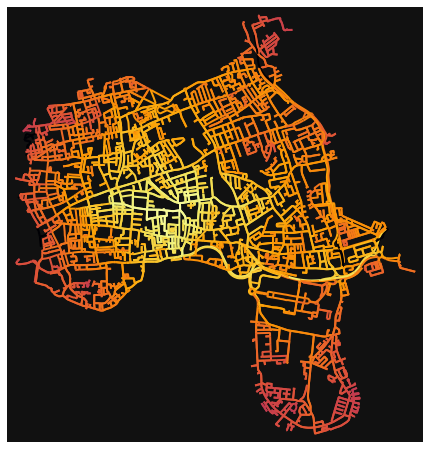

In [63]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Routing

In [64]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [65]:
# get the nearest network nodes to two lat/lng points with the distance module
dest = ox.distance.nearest_nodes(G, X=-0.006168, Y=51.510012)
orig = ox.distance.nearest_nodes(G, X=-0.056906, Y=51.519395)

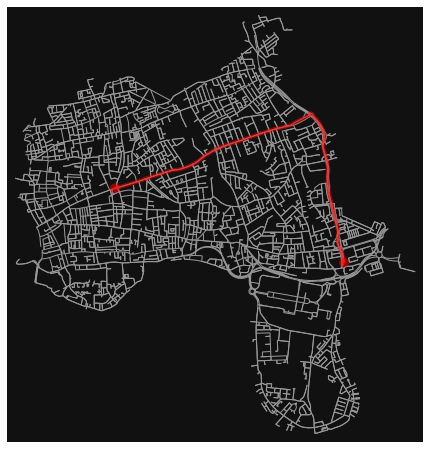

In [66]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [36]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
round(sum(edge_lengths))

5626

In [37]:
# how far is it between these two nodes as the crow flies?
# use OSMnx's vectorized great-circle distance (haversine) function
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle_vec(orig_y, orig_x, dest_y, dest_x))

3639

## Graphs from other osm layer types

...like rail or electric grids or canals, using the `custom_filter` parameter: [see more examples](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/08-custom-filters-infrastructure.ipynb).

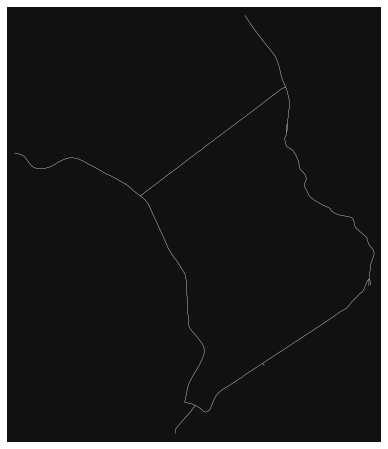

In [39]:
# get lbth canals
G = ox.graph_from_place(
    "London Borough of Tower Hamlets, London, UK",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["waterway"~"canal"]',
)

fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

## features from other osm layer types

...like parks, using the `custom_filter` parameter: [see more examples](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/08-custom-filters-infrastructure.ipynb).

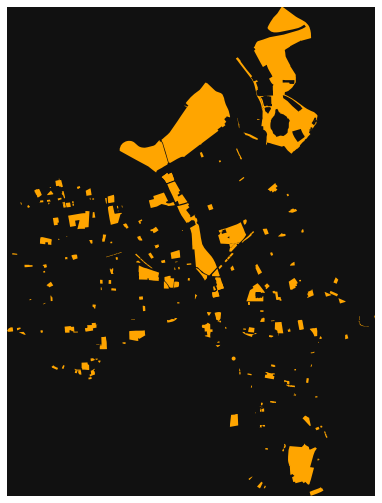

In [75]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park"}
fig, ax = ox.plot_footprints(ox.geometries_from_place(place, tags), figsize=(9, 9))